# Stroke data EDA

## Data loading

The data I will be working in this project is about predicting stroke  
from some health data.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import joblib

from my_funcs import *

In [3]:
data = pd.read_csv("health_data.csv")
data.drop("id", axis=1, inplace=True)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
data.shape

(5110, 11)

In [5]:
data.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
data.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

There are some missing values in the bmi columns, also  
seems like some values that are actually categories  
e.g. `hypertension` are coded as numbers.

## Data inspection

In [7]:
data.describe().style.format("{:.2f}")

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.00,5110.00,5110.00,4909.00,5110.00
mean,43.23,0.10,0.05,106.15,28.89,0.05
std,22.61,0.30,0.23,45.28,7.85,0.22
min,0.08,0.00,0.00,55.12,10.30,0.00
25%,25.00,0.00,0.00,77.25,23.50,0.00
50%,45.00,0.00,0.00,91.88,28.10,0.00
75%,61.00,0.00,0.00,114.09,33.10,0.00
max,82.00,1.00,1.00,271.74,97.60,1.00


Only 5 percent of people in the dataset had a stroke.

In [8]:
data.sort_values("age").head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3295,Male,0.08,0,0,No,children,Rural,70.33,16.9,Unknown,0
1614,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0
3618,Male,0.16,0,0,No,children,Urban,114.71,17.4,Unknown,0


Some ages were very small, looks like children are also included.

In [9]:
import duckdb as ddb

child = ddb.query(
    """
    SELECT work_type,
           AVG(age) avg_age,
           AVG(avg_glucose_level) avg_glucose,
           AVG(bmi) avg_bmi,
           AVG(stroke) avg_stroke,
           SUM(stroke) stroke_count,
           COUNT(stroke) total_count
    FROM data
    GROUP BY work_type
    """
).to_df()
child.set_index("work_type").style.format("{:.3f}")

,avg_age,avg_glucose,avg_bmi,avg_stroke,stroke_count,total_count
work_type,,,,,,
Private,45.504,106.797,30.305,0.051,149.000,2925.000
Self-employed,60.201,112.645,30.212,0.079,65.000,819.000
Govt_job,50.880,107.780,30.522,0.050,33.000,657.000
children,6.841,94.400,20.038,0.003,2.000,687.000
Never_worked,16.182,96.043,25.545,0.000,0.000,22.000


Logically children and people who never worked are younger and have  
lover bmi and glucose values.

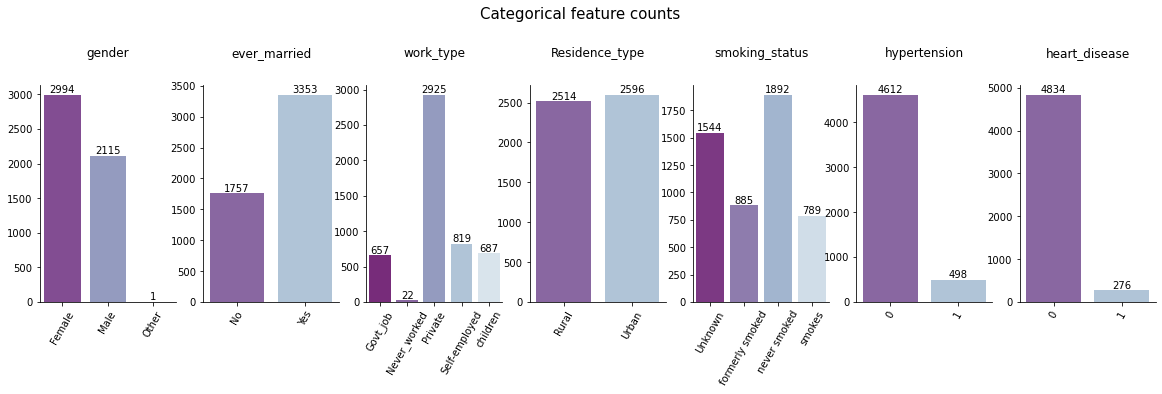

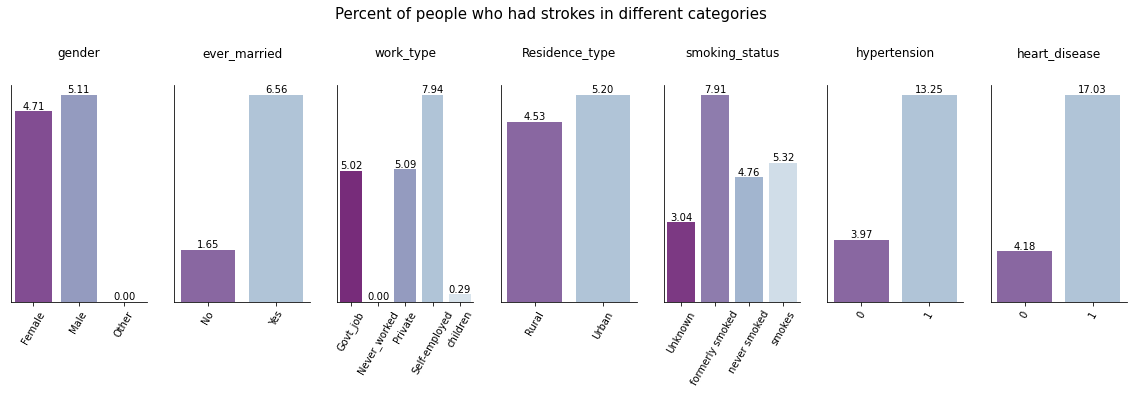

In [10]:
categorical = data.select_dtypes("object").columns
categorical_cols = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
    "hypertension",
    "heart_disease",
]
fig, ax = plt.subplots(1, len(categorical_cols), figsize=(20, 4))

for i, feat in enumerate(categorical_cols):
    axi = ax.flatten()[i]
    count_feat = data[feat].value_counts().sort_index()
    sns.barplot(
        x=count_feat.index,
        y=count_feat.values,
        palette="BuPu_r",
        ax=axi,
    )
    axi.set_title(feat, y=1.1)
    axi.set_xticklabels(axi.get_xticklabels(), rotation=60)
    vert_annot(axi)
sns.despine()
fig.suptitle("Categorical feature counts", y=1.15, fontsize=15)

fig, ax = plt.subplots(1, len(categorical_cols), figsize=(20, 4))

for i, feat in enumerate(categorical_cols):
    axi = ax.flatten()[i]
    num_stroke = data.groupby(feat)["stroke"].sum().sort_index()
    num_total = data[feat].value_counts().sort_index()
    stroke_percent = round((num_stroke / num_total) * 100, 2)
    sns.barplot(
        x=stroke_percent.index, y=stroke_percent.values, palette="BuPu_r", ax=axi
    )
    axi.set_xticklabels(axi.get_xticklabels(), rotation=60)
    axi.set_xlabel("")
    axi.set_title(feat, y=1.1)
    axi.set_yticks([])
    vert_annot(axi, 2)
sns.despine()
fig.suptitle(
    "Percent of people who had strokes in different categories", y=1.15, fontsize=15
)
plt.show()

In [11]:
pd.DataFrame(data.groupby("smoking_status")["age"].mean()).style.format("{:.2f}")

,age
smoking_status,
Unknown,30.23
formerly smoked,54.93
never smoked,46.74
smokes,47.10


Some categories seem to have higher rates of stroke like married people, smokers and privately  
employed people. All of these examples might have higher stroke rates because of their age.

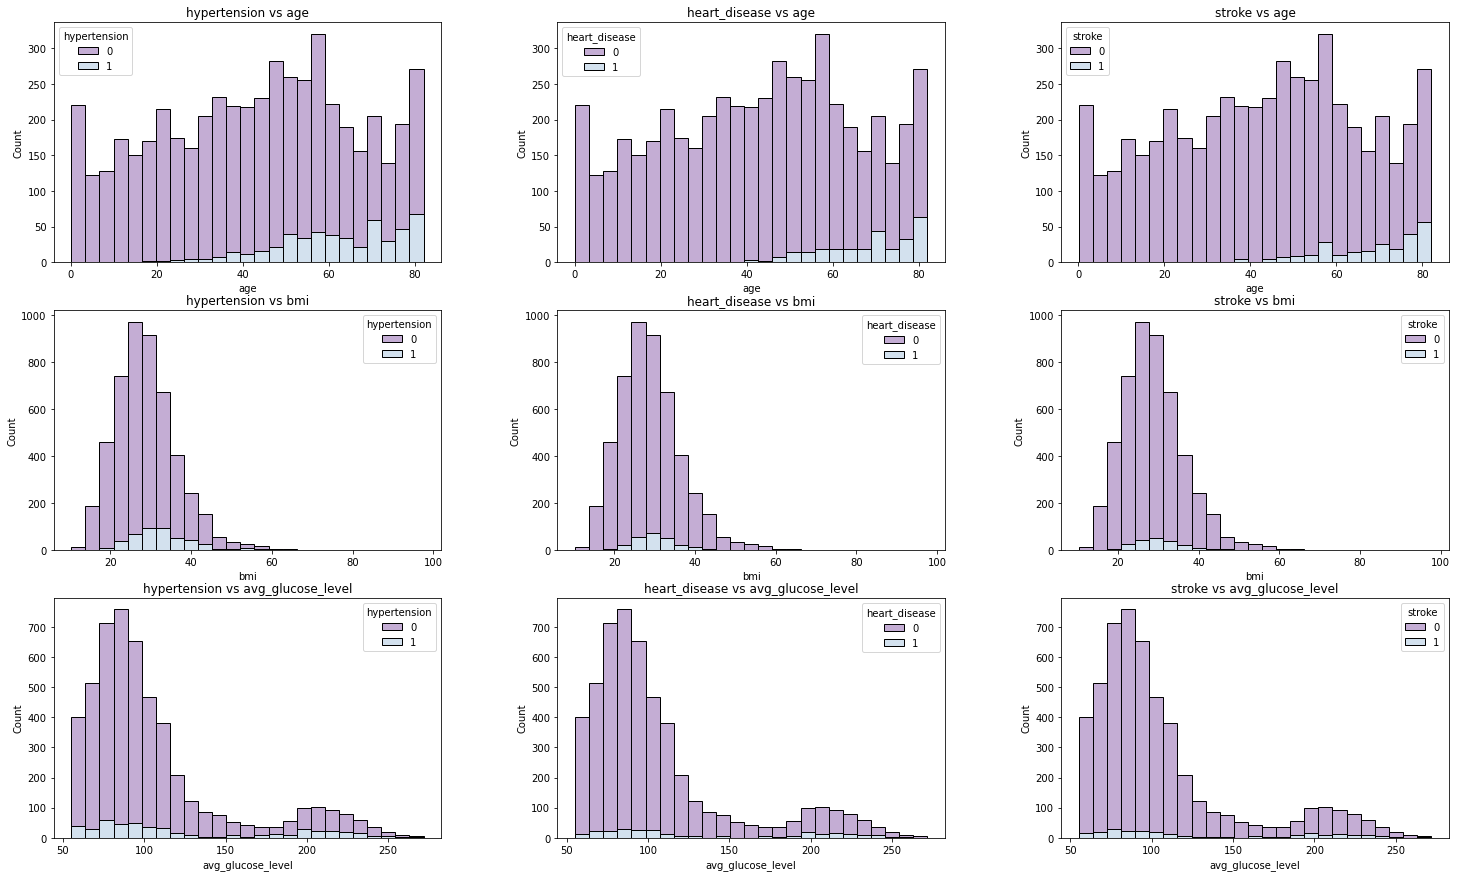

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(25, 15))
fig.subplots_adjust(wspace=0.3)

for i, feat in enumerate(["hypertension", "heart_disease", "stroke"]):
    axi = ax.flatten()[i]
    sns.histplot(
        data=data,
        x="age",
        hue=feat,
        alpha=0.5,
        multiple="stack",
        bins=25,
        palette="BuPu_r",
        ax=axi,
    )
    axi.set_title(f"{feat} vs age")
    axi.set_xlabel("age")

for i, feat in enumerate(["hypertension", "heart_disease", "stroke"]):
    axi = ax.flatten()[i + 3]
    sns.histplot(
        data=data,
        x="bmi",
        hue=feat,
        alpha=0.5,
        multiple="stack",
        bins=25,
        palette="BuPu_r",
        ax=axi,
    )
    axi.set_title(f"{feat} vs bmi")
    axi.set_xlabel("bmi")

for i, feat in enumerate(["hypertension", "heart_disease", "stroke"]):
    axi = ax.flatten()[i + 6]
    sns.histplot(
        data=data,
        x="avg_glucose_level",
        hue=feat,
        alpha=0.5,
        multiple="stack",
        bins=25,
        palette="BuPu_r",
        ax=axi,
    )
    axi.set_title(f"{feat} vs avg_glucose_level")
    axi.set_xlabel("avg_glucose_level")
plt.show()

Conditions like heart disease, hypertension are pretty rare just as stroke is,  
we can also see double peaks in glucose level, probably separating people with  
and without diabetes.

Seems like hypertension, heart disease and stroke are all a lot more  
common in older ages, whereas there is no clear relationship between  
bmi and glucose levels with these conditions.

## Correlations

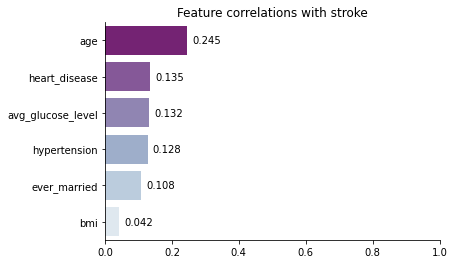

In [13]:
coor_data = data.copy()
coor_data["ever_married"] = coor_data["ever_married"].apply(
    lambda x: 1 if x == "Yes" else 0
)
corr_stroke = coor_data.corr()["stroke"].sort_values(ascending=False)[1:]

ax = sns.barplot(
    x=corr_stroke.values, y=corr_stroke.index, palette="BuPu_r", orient="h"
)
hori_annot(ax, 3)
sns.despine()
ax.set_title("Feature correlations with stroke")
plt.xlim(0, 1)
plt.show()

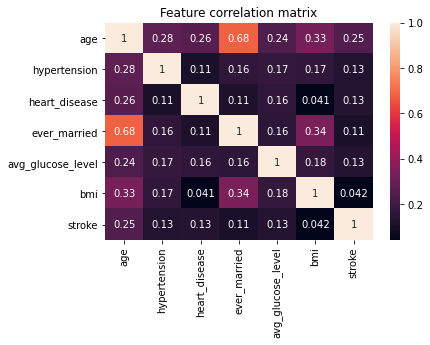

In [14]:
sns.heatmap(coor_data.corr(), annot=True)
plt.title("Feature correlation matrix")
plt.show()

Most correlated feature with stroke is age, but even it is  
not very highly correlated, the highest correlation overall  
is between age and marriage. Also age is relatively highly correlated  
with all other features.

## Are you really more likely to have a stroke if you are married?

In [15]:
married = data.loc[data.ever_married == "Yes"].stroke
not_married = data.loc[data.ever_married == "No"].stroke

lb, mean_diff, ub, diffs = boot_mean_diff_ci(married, not_married, 10000)

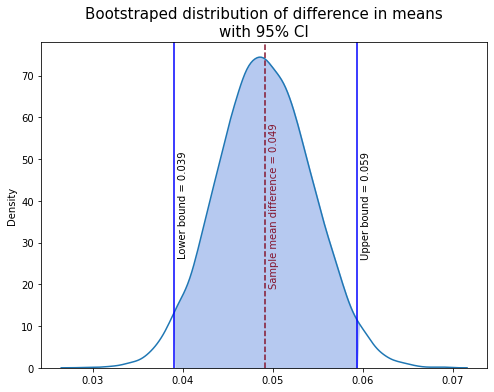

In [16]:
plot_ci(diffs, lb, mean_diff, ub)

In [17]:
p_value, mean_diff, diffs = permute_p(married, not_married, n_perm=10000, alt="greater")

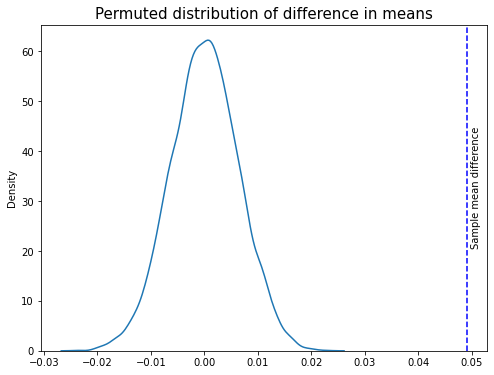

In [18]:
plot_pvalue(diffs, mean_diff, p_value, alt="greater")

Seems like married people are more likely to have strokes, but lets see if that   
might be explained by married people being older in general.

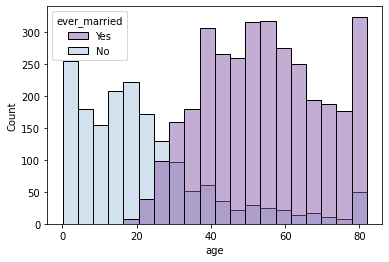

In [19]:
sns.histplot(data=data, x="age", hue="ever_married", palette="BuPu_r")
plt.show()

Seems like that might very well be.

# Machine learning models

## Stroke prediction

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

import xgboost as xgb
import lightgbm as lgbm
import catboost as cat
from catboost import CatBoostClassifier, metrics

/Users/matas/miniconda3/envs/lab/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [21]:
y = data["stroke"].copy()
X = data.copy()
X.drop("stroke", axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

X_train, X_eval, y_train, y_eval = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.2, random_state=42
)

Creating both a test and a separate validation set for early stopping with. 
boosted tree models.

In [22]:
def make_pipe(X: pd.DataFrame, sampler="passthrough") -> Pipeline:
    """
    Helper function for creating pipelines for given data.
    """

    x_cat = X.select_dtypes("object").columns
    x_num = X.select_dtypes(np.number).columns

    num_pipe = Pipeline([("knn_imp", KNNImputer()), ("scale", StandardScaler())])

    categories = [[i for i in X[col].unique() if i is not np.nan] for col in x_cat]
    cat_transform = ColumnTransformer(
        [
            ("cat", OneHotEncoder(drop="if_binary", categories=categories), x_cat),
            ("num", num_pipe, x_num),
        ]
    )

    pipe = ImPipeline(
        [("cat_trans", cat_transform), ("sample", sampler), ("model", None)]
    )
    return pipe

In [23]:
pipe = make_pipe(X, sampler=SMOTE())

The classes for stroke in the dataset a very imbalanced, so I will try using SMOTE.

In [24]:
from scipy import stats
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    ExtraTreesClassifier,
    ExtraTreesRegressor,
    AdaBoostClassifier,
    AdaBoostRegressor,
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import xgboost as xgb
import catboost as cat
from catboost import Pool

classification_models = {
    "SVC": {
        "model": [SVC()],
        "model__C": stats.loguniform(1e-3, 1e3),
    },
    "LogisticRegression": {
        "model": [LogisticRegression()],
        "model__C": stats.loguniform(1e-3, 1e3),
        "model__max_iter": [10_000],
    },
    "RandomForestClassifier": {
        "model": [RandomForestClassifier()],
        "model__n_estimators": stats.randint(100, 1000),
        "model__min_samples_leaf": stats.randint(1, 10),
    },
    "ExtraTreesClassifier": {
        "model": [ExtraTreesClassifier()],
        "model__n_estimators": stats.randint(100, 1000),
        "model__min_samples_leaf": stats.randint(1, 10),
    },
    "AdaBoostClassifier": {
        "model": [AdaBoostClassifier()],
        "model__n_estimators": stats.randint(25, 75),
        "model__learning_rate": stats.loguniform(1e-3, 1),
    },
    "KNeighborsClassifier": {
        "model": [KNeighborsClassifier()],
        "model__n_neighbors": stats.randint(3, 8),
    },
    "XGBoost": {
        "model": [xgb.XGBClassifier(verbosity=0, use_label_encoder=False)],
        "model__learning_rate": stats.loguniform(3e-3, 0.05),
        "model__n_estimators": stats.randint(200, 2000),
        "model__max_depth": stats.randint(1, 5),
        "model__min_child_weight": stats.randint(1, 10),
        "model__gamma": stats.uniform(0, 20),
        "model__reg_alpha": stats.uniform(1e-3, 10),
        "model__reg_lambda": stats.uniform(1e-3, 10),
    },
    "LightGBM": {
        "model": [lgbm.LGBMClassifier()],
        "model__n_estimators": stats.randint(200, 2000),
        "model__num_leaves": stats.randint(8, 200),
        "model__max_depth": stats.randint(3, 12),
        "model__learning_rate": stats.loguniform(3e-3, 0.05),
        "model__reg_alpha": stats.randint(0, 100),
        "model__reg_lambda": stats.randint(0, 100),
    },
    "Catboost": {
        "model": [CatBoostClassifier(verbose=False)],
        "model__iterations": stats.randint(200, 2000),
        "model__l2_leaf_reg": stats.randint(2, 60),
    },
}

For starters I will screen various machine learning models and then select the best.  
For scoring I will use balanced accuracy to make sure we are taking into account for  
the rarer stroke class, because in this case we mostly care of making sure we notice  
people who might have strokes.

In [25]:
# stroke_model = EstimatorSelectionHelper(classification_models, pipe)
# stroke_model.make_random_searches()
# stroke_model.fit(X_train, y_train, scoring="balanced_accuracy")

In [ ]:
# joblib.dump(stroke_model, "models/stroke_model.dump")
stroke_model = joblib.load("models/stroke_model.dump")

In [27]:
search_results = (
    stroke_model.score_summary()
    .sort_values(["mean_score", "estimator"], ascending=False)
    .groupby("estimator")
    .head(1)
)
search_results

,estimator,min_score,mean_score,max_score,std_score,params
27,LogisticRegression,0.740703,0.773601,0.818677,0.032977,"{'model': LogisticRegression(), 'model__C': 0...."
19,SVC,0.748166,0.765415,0.798594,0.023467,"{'model': SVC(), 'model__C': 0.016085970760286..."
172,XGBoost,0.740476,0.76138,0.786106,0.018824,"{'model': XGBClassifier(base_score=None, boost..."
106,AdaBoostClassifier,0.740476,0.759699,0.781473,0.016834,"{'model': AdaBoostClassifier(), 'model__learni..."
93,ExtraTreesClassifier,0.62266,0.646443,0.660047,0.016875,"{'model': ExtraTreesClassifier(), 'model__min_..."
179,LightGBM,0.628848,0.642697,0.653357,0.010257,"{'model': LGBMClassifier(), 'model__learning_r..."
125,KNeighborsClassifier,0.577643,0.627088,0.663138,0.036165,"{'model': KNeighborsClassifier(), 'model__n_ne..."
63,RandomForestClassifier,0.535377,0.554055,0.566413,0.013435,"{'model': RandomForestClassifier(), 'model__mi..."
206,Catboost,0.540493,0.545447,0.549017,0.003615,{'model': <catboost.core.CatBoostClassifier ob...


Seems like a simple logistic regression performed best in this case.
Surprising that such models as catboost did pretty poorly, maybe it is  
because we are not using the full capabilities of these frameworks.

In [28]:
log_model = pipe.set_params(**search_results.head(1).params.values[0])
_ = log_model.fit(X_train, y_train)

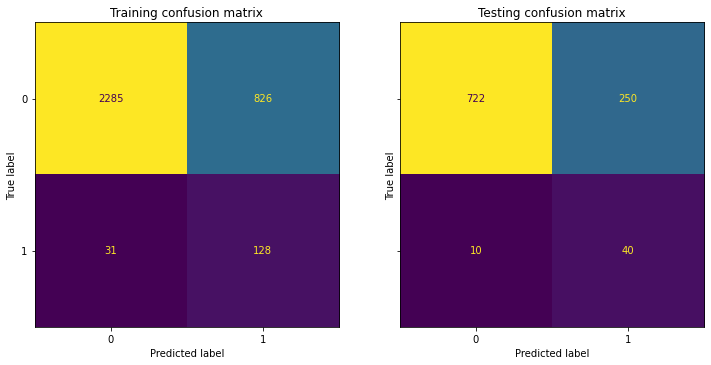

In [29]:
compare_cf_matrix(
    log_model, X_train, X_test, y_train, y_test, size=(12, 8), normalize=None
)

In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_test, log_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85       972
           1       0.14      0.80      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.75      0.82      1022



After retraining the model with found parameter we see it makes a lot of false positives  
but more importantly it has high recall for the stroke class.

### Stroke XGBoost

Next lets try playing around and improving the boosted tree models.

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [32]:
x_cat = X.select_dtypes("object").columns
x_num = X.select_dtypes(np.number).columns

num_pipe = Pipeline([("knn_imp", KNNImputer()), ("scale", StandardScaler())])
categories = [[i for i in X[col].unique() if i is not np.nan] for col in x_cat]
col_transform = ColumnTransformer(
    [
        ("cat", OneHotEncoder(drop="if_binary", categories=categories), x_cat),
        ("num", num_pipe, x_num),
    ]
)

In [33]:
def xgboost_objective(trial, X, y, col_transform):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300, step=20),
        "max_depth": trial.suggest_int("max_depth", 1, 5),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 96, step=5),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 100, step=5),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 100, step=5),
        "gama": trial.suggest_float("gama", 0, 20),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = np.empty(5)

    for idx, (train_idx, eval_idx) in enumerate(cv.split(X, y)):
        X_train, X_eval = X.iloc[train_idx], X.iloc[eval_idx]
        y_train, y_eval = y.iloc[train_idx], y.iloc[eval_idx]

        X_train = col_transform.fit_transform(X_train)
        X_eval = col_transform.transform(X_eval)

        model = xgb.XGBClassifier(verbosity=0, use_label_encoder=0, **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_eval, y_eval)],
            eval_metric="logloss",
            early_stopping_rounds=100,
            verbose=False,
        )
        preds = model.predict(X_eval)
        cv_scores[idx] = balanced_accuracy_score(y_eval, preds)

    return -np.mean(cv_scores)

For model optimization i will try using optuna, because it allows more flexibility  
on which parameters I am optimizing and how. Again will be optimizing for balanced  
accuracy.

In [34]:
# xgb_study = optuna.create_study(direction="minimize", study_name="XGB")
# func = lambda trial: xgboost_objective(trial, X_train, y_train, col_transform)
# xgb_study.optimize(func, n_trials=250)
# joblib.dump(xgb_study, "models/xgb_study.dump")
xgb_study = joblib.load("models/xgb_study.dump")

In [35]:
tuned_params = xgb_study.best_params
tuned_params

{'n_estimators': 10000,
 'learning_rate': 0.034384988610727106,
 'num_leaves': 220,
 'max_depth': 2,
 'scale_pos_weight': 16,
 'reg_alpha': 90,
 'reg_lambda': 30,
 'gama': 16.21936478096073,
 'min_child_weight': 6}

/var/folders/vk/9l9tsqkn5td6vys4n4fjtlr80000gn/T/ipykernel_7052/3015938784.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(xgb_study)


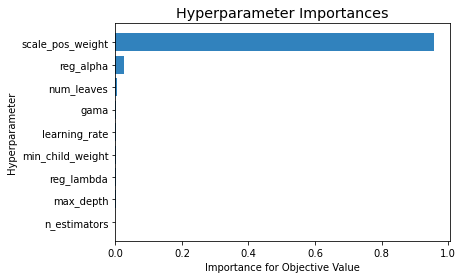

In [36]:
optuna.visualization.matplotlib.plot_param_importances(xgb_study)
plt.show()

Looking at parameter importances we see that class weights was the most important  
parameter for improving balanced accuracy.

In [37]:
col_transform.fit(X_train)
xgb_model = Pipeline(
    [
        ("trans", col_transform),
        ("model", xgb.XGBClassifier(verbosity=0, use_label_encoder=0, **tuned_params)),
    ]
)
_ = xgb_model.fit(
    X_train,
    y_train,
    model__eval_set=[(col_transform.transform(X_eval), y_eval)],
    model__eval_metric="logloss",
    model__early_stopping_rounds=100,
    model__verbose=False,
)

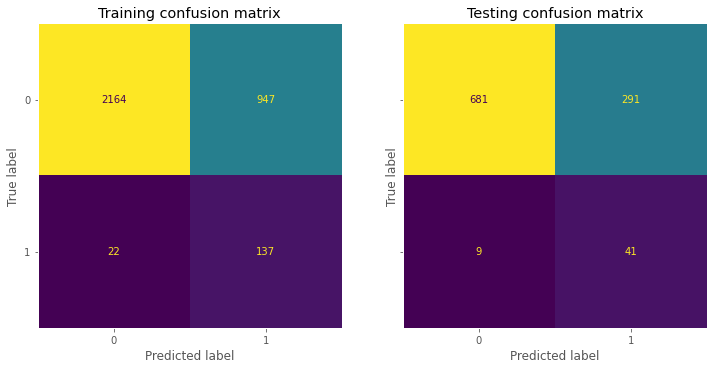

In [38]:
compare_cf_matrix(
    xgb_model,
    X_train,
    X_test,
    y_train,
    y_test,
    size=(12, 8),
    normalize=None,
)
plt.show()

In [39]:
print(classification_report(y_test, xgb_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.70      0.82       972
           1       0.12      0.82      0.21        50

    accuracy                           0.71      1022
   macro avg       0.56      0.76      0.52      1022
weighted avg       0.94      0.71      0.79      1022



As we can see we improved recall for stroke slightly but we are  
also making even more false positives than with simple logistic  
regression.

In [40]:
round(
    balanced_accuracy_score(
        y_test,
        xgb_model.predict(X_test),
    ),
    2,
)

0.76

The balanced accuracy is also similar to our fist results.

### Stroke LightGBM

Next lets move on to lightGBM.

In [41]:
from lightgbm import early_stopping
from lightgbm import log_evaluation

In [42]:
def lgbm_objective(trial, X, y, col_transform):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 10, 200, step=10),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 100, step=5),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 100, step=5),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = np.empty(5)

    for idx, (train_idx, eval_idx) in enumerate(cv.split(X, y)):
        X_train, X_eval = X.iloc[train_idx], X.iloc[eval_idx]
        y_train, y_eval = y.iloc[train_idx], y.iloc[eval_idx]

        X_train = col_transform.fit_transform(X_train)
        X_eval = col_transform.transform(X_eval)

        model = lgbm.LGBMClassifier(objective="binary", is_unbalance=True, **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_eval, y_eval)],
            eval_metric="binary_logloss",
            callbacks=[
                early_stopping(100, verbose=False),
            ],
        )
        preds = model.predict(X_eval)
        cv_scores[idx] = balanced_accuracy_score(y_eval, preds)

    return -np.mean(cv_scores)

Again using optuna for optimization.

In [43]:
# lgbm_study = optuna.create_study(direction="minimize", study_name="LightGBM")
# func = lambda trial: lgbm_objective(trial, X_train, y_train, col_transform)
# lgbm_study.optimize(func, n_trials=250)
# joblib.dump(lgbm_study, "lgbm_study.dump")
lgbm_study = joblib.load("models/lgbm_study.dump")

In [44]:
tuned_params = lgbm_study.best_params
tuned_params

{'n_estimators': 10000,
 'learning_rate': 0.2797661728663074,
 'num_leaves': 40,
 'max_depth': 9,
 'reg_alpha': 45,
 'reg_lambda': 10}

/var/folders/vk/9l9tsqkn5td6vys4n4fjtlr80000gn/T/ipykernel_7052/1005970686.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(lgbm_study)


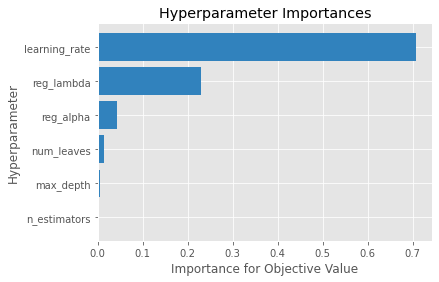

In [45]:
optuna.visualization.matplotlib.plot_param_importances(lgbm_study)
plt.show()

In this case probably because we used the `is_balanced=False` flag the most important  
parameters were learning_rate and regularization parameters.

In [46]:
lgbm_model = Pipeline(
    [
        ("trans", col_transform),
        ("model", lgbm.LGBMClassifier(is_unbalance=True, **tuned_params)),
    ]
)
_ = lgbm_model.fit(
    X_train,
    y_train,
    model__eval_set=[(col_transform.transform(X_eval), y_eval)],
    model__eval_metric="binary_logloss",
    model__callbacks=[
        early_stopping(100),
    ],
)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.457582


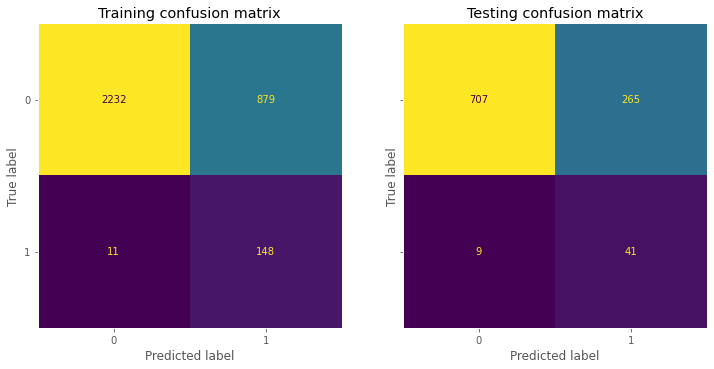

In [47]:
compare_cf_matrix(
    lgbm_model,
    X_train,
    X_test,
    y_train,
    y_test,
    size=(12, 8),
    normalize=None,
)
plt.show()

In [48]:
print(classification_report(y_test, lgbm_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84       972
           1       0.13      0.82      0.23        50

    accuracy                           0.73      1022
   macro avg       0.56      0.77      0.53      1022
weighted avg       0.95      0.73      0.81      1022



We again see the same recall for stroke as XGBoost, but we now have lower amount of  
false positives.

In [49]:
round(
    balanced_accuracy_score(
        y_test,
        lgbm_model.predict(X_test),
    ),
    2,
)

0.77

In this case our accuracy improved a bit.

### Stroke CatBoost

Finally lets try out catboost.

In [50]:
cat_data = data.copy(deep=True)
cat_data = cat_data.astype({"hypertension": object, "heart_disease": object})
obj = [col for col in cat_data.columns if cat_data[col].dtypes == "object"]
cat_data = cat_data.astype({col: "category" for col in obj})

In [51]:
cat_cols = [
    i for i, col in enumerate(cat_data.columns) if cat_data[col].dtypes == "category"
]

In [52]:
def cat_objective(trial, X, y):
    param_grid = {
        "iterations": trial.suggest_categorical("iterations", [10000]),
        "depth": trial.suggest_int("depth", 2, 10),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 0, 100, step=5),
        "bagging_temperature": trial.suggest_int("bagging_temperature", 0, 50),
        "random_strength": trial.suggest_int("random_strength", 0, 10),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = np.empty(5)

    for idx, (train_idx, eval_idx) in enumerate(cv.split(X, y)):
        X_train, X_eval = X.iloc[train_idx], X.iloc[eval_idx]
        y_train, y_eval = y.iloc[train_idx], y.iloc[eval_idx]

        train_data = Pool(
            data=X_train,
            label=y_train,
            cat_features=cat_cols,
        )
        eval_data = Pool(
            data=X_eval,
            label=y_eval,
            cat_features=cat_cols,
        )

        model = cat.CatBoostClassifier(auto_class_weights="Balanced", **param_grid)
        model.fit(
            train_data,
            eval_set=[eval_data],
            early_stopping_rounds=100,
            verbose=0,
        )
        preds = model.predict(X_eval)
        cv_scores[idx] = balanced_accuracy_score(y_eval, preds)

    return -np.mean(cv_scores)

This time I won't do any preprocessing and use the built in categorical functionality of  
catboost.

In [53]:
# cat_study = optuna.create_study(direction="minimize", study_name="Catboost")
# func = lambda trial: cat_objective(trial, X_train, y_train)
# cat_study.optimize(func, n_trials=100)
# joblib.dump(cat_study, "models/cat_study.dump")
cat_study = joblib.load("models/cat_study.dump")

In [54]:
tuned_params = cat_study.best_params
tuned_params

{'iterations': 10000,
 'depth': 10,
 'l2_leaf_reg': 35,
 'bagging_temperature': 50,
 'random_strength': 7}

/var/folders/vk/9l9tsqkn5td6vys4n4fjtlr80000gn/T/ipykernel_7052/1478673376.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(cat_study)


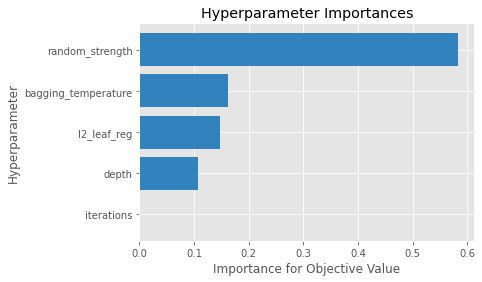

In [55]:
optuna.visualization.matplotlib.plot_param_importances(cat_study)
plt.show()

Again parameters reducing overfitting were the most important ones.

In [56]:
train_data = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_cols,
)
eval_data = Pool(
    data=X_eval,
    label=y_eval,
    cat_features=cat_cols,
)

cat_model = cat.CatBoostClassifier(auto_class_weights="Balanced", **tuned_params)
cat_model.fit(
    train_data,
    eval_set=[(eval_data)],
    early_stopping_rounds=100,
    verbose=0,
)

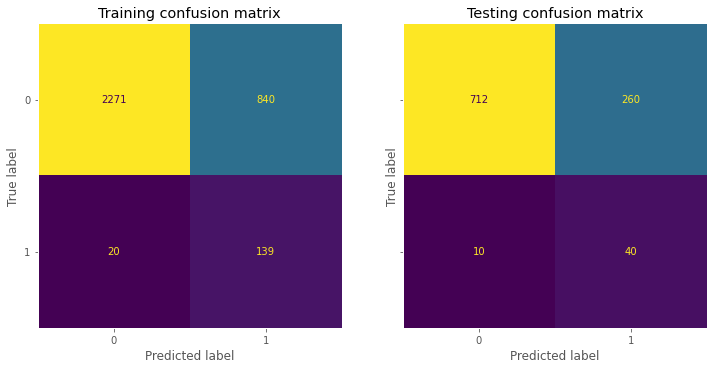

In [57]:
compare_cf_matrix(
    cat_model, X_train, X_test, y_train, y_test, size=(12, 8), normalize=None
)
plt.show()

In [58]:
print(classification_report(y_test, cat_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84       972
           1       0.13      0.80      0.23        50

    accuracy                           0.74      1022
   macro avg       0.56      0.77      0.53      1022
weighted avg       0.94      0.74      0.81      1022



In this case we are getting the same recall as logistic regression  
but our false negatives are not as good.  

In [59]:
round(
    balanced_accuracy_score(
        y_test,
        cat_model.predict(X_test),
    ),
    2,
)

0.77

For cat boost the balanced accuracy score really improved, must  
have been because of using the native way for encoding categorical data.

Seems like Logistic regression really was a pretty good model.

### Stroke model error analysis

In [60]:
def false_negatives(model, X_test, y_test, data):
    pred = model.predict(X_test)
    fn = (y_test == 1) & (pred == 0)

    return data.loc[fn]

In [61]:
xgb_fn = false_negatives(xgb_model, X_test, y_test, X_test)
xgb_fn_proba = xgb_model.predict_proba(xgb_fn)
xgb_df = pd.DataFrame(
    np.hstack([xgb_fn.reset_index(), xgb_fn_proba]),
    columns=["index"] + list(X_train.columns) + ["xgb_proba0", "xgb_proba1"],
)

lgbm_fn = false_negatives(lgbm_model, X_test, y_test, X_test)
lgbm_fn_proba = lgbm_model.predict_proba(lgbm_fn)
lgbm_df = pd.DataFrame(
    np.hstack([lgbm_fn.reset_index(), lgbm_fn_proba]),
    columns=["index"] + list(X_train.columns) + ["lgbm_proba0", "lgbm_proba1"],
)

cat_fn = false_negatives(cat_model, X_test, y_test, X_test)
cat_fn_proba = cat_model.predict_proba(cat_fn)
cat_df = pd.DataFrame(
    np.hstack([cat_fn.reset_index(), cat_fn_proba]),
    columns=["index"] + list(X_train.columns) + ["cat_proba0", "cat_proba1"],
)

In [62]:
pd.merge(xgb_df, lgbm_df, how="outer").merge(cat_df, how="outer")

/Users/matas/miniconda3/envs/lab/lib/python3.9/site-packages/pandas/core/reshape/merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


,index,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,xgb_proba0,xgb_proba1,lgbm_proba0,lgbm_proba1,cat_proba0,cat_proba1
0,133.0,Female,38.0,0.0,0.0,Yes,Private,Rural,101.45,NaN,formerly smoked,0.890162,0.109838,0.864468,0.135532,0.721235,0.278765
1,94.0,Male,45.0,0.0,0.0,Yes,Private,Rural,64.14,29.4,never smoked,0.764445,0.235555,0.886593,0.113407,0.836329,0.163671
2,182.0,Female,32.0,0.0,0.0,Yes,Private,Rural,76.13,29.9,smokes,0.922356,0.077644,0.947267,0.052733,0.904732,0.095268
3,88.0,Male,47.0,0.0,0.0,Yes,Private,Urban,86.94,41.1,formerly smoked,0.76251,0.23749,0.9067,0.0933,0.669425,0.330575
4,80.0,Male,59.0,0.0,0.0,Yes,Private,Rural,96.16,44.1,Unknown,0.507447,0.492553,0.581482,0.418518,0.553069,0.446931
5,210.0,Female,39.0,0.0,0.0,Yes,Private,Urban,83.24,26.3,never smoked,0.890517,0.109483,0.827194,0.172806,0.86389,0.13611
6,245.0,Female,14.0,0.0,0.0,No,children,Rural,57.93,30.9,Unknown,0.915355,0.084645,0.956925,0.043075,0.962046,0.037954
7,31.0,Male,42.0,0.0,0.0,Yes,Private,Rural,83.41,25.4,Unknown,0.890517,0.109483,0.922182,0.077818,0.860488,0.139512
8,228.0,Female,39.0,0.0,0.0,Yes,Self-employed,Urban,97.76,29.6,smokes,0.876329,0.123671,0.868211,0.131789,0.842376,0.157624
9,38,Male,58.0,0,0,No,Private,Rural,92.62,32.0,Unknown,NaN,NaN,NaN,NaN,0.600726,0.399274


First lets loot at the instances which were false negative as these are the most important  
for us. From the first look all of these values seem like outliers, especially the 14 year  
old girl, from the data we have it would be very dificult to say she could have a stroke  
seems like more information would be needed to make accurate prediction in this case.  

Now lets try using shap values and lets figure out which features are important for prediction.

In [63]:
feature_names = []
for i, col in enumerate(x_cat):
    if len(categories[i]) < 3:
        feature_names.append(col)
        continue
    for category in categories[i]:
        feature_names.append(f"{col}_{category}")
feature_names += list(x_num)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


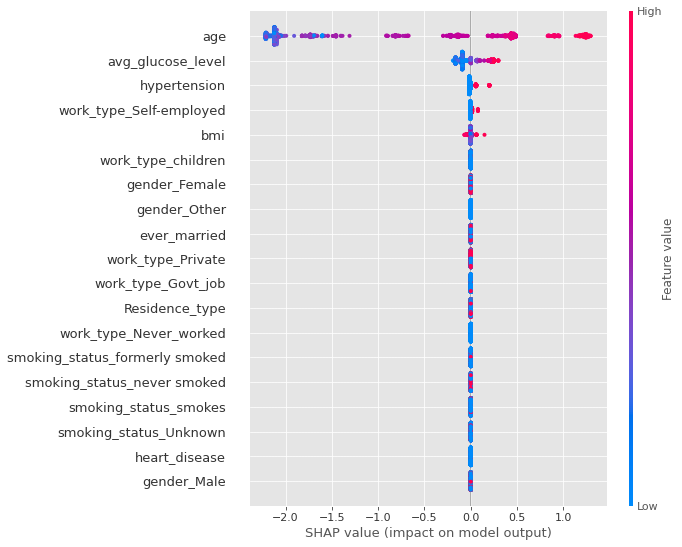

In [64]:
import shap

xgb_explainer = shap.TreeExplainer(xgb_model["model"])
xgb_shap_values = xgb_explainer(col_transform.transform(X_test))
shap.summary_plot(xgb_shap_values, feature_names=feature_names)

For XGBoost as expected from correlation data age is the most important feature followed   
by glucose levels. Other features are pretty much useless apart from people with hypertension  
and some self-employed persons.

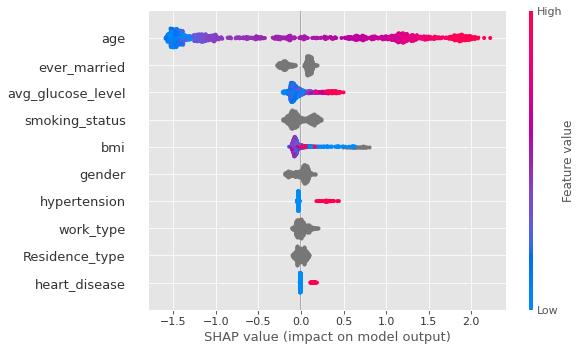

In [65]:
cat_explainer = shap.TreeExplainer(cat_model)
cat_shap_values = cat_explainer(X_test)
shap.plots.beeswarm(cat_shap_values)

With catboost the story is similar, age is the most important one, overall all
features have a bit more say in the result.

In [66]:
pd.DataFrame(log_model["model"].coef_, columns=feature_names).T.sort_values(
    0, ascending=False
).T

,age,avg_glucose_level,smoking_status_formerly smoked,hypertension,work_type_Private,heart_disease,smoking_status_smokes,gender_Female,gender_Other,work_type_Never_worked,work_type_Self-employed,work_type_Govt_job,work_type_children,smoking_status_Unknown,bmi,gender_Male,Residence_type,ever_married,smoking_status_never smoked
0,1.316361,0.230478,0.133693,0.118157,0.10374,0.083797,0.078416,0.075255,-0.000791,-0.002879,-0.022541,-0.037218,-0.041111,-0.042427,-0.058434,-0.074472,-0.095859,-0.100042,-0.169691


For the simple but well performing Logistic Regression model age was also  
by far the most important factor in predicting strokes.  

Now lets examine some examples where the model made false negative mistakes  
looking at the examples with lowest and highest ages.

In [67]:
shap.initjs()
shap.plots.force(
    xgb_shap_values[X_test.index.get_loc(245)], feature_names=feature_names
)

In [68]:
shap.plots.force(cat_shap_values[X_test.index.get_loc(245)])

In [69]:
shap.plots.force(xgb_shap_values[X_test.index.get_loc(80)], feature_names=feature_names)

In [70]:
shap.plots.force(cat_shap_values[X_test.index.get_loc(80)])

As expected in the 14 year old case age had the most impact but even the other  
values pushed the prediction to no stroke.

For the older case we can see that the prediction is borderline with the glucose  
level and bmi pushing it in xgboosts case and more factors pushing it in the catboost  
model.

## Ensemble

In this part I will make an ensemble of models for predicting  
stroke, even though it does seem unnecessary as a simple  
LogisticRegression performs the best in this case. So this is  
simply for experimenting and in a real world scenario I would  
not exchange a simple, fast, easy to understand regression model  
to a mix of more black box forest models that don't even perform  
as well.

In [71]:
from sklearn.base import BaseEstimator, ClassifierMixin


class MyEnsembleClassifier(BaseEstimator, ClassifierMixin):
    """
    Class that takes multiple trained binary classification models
    and predicts the outcome based on the average prediction probability
    of all models
    """

    def __init__(self, models: []):
        self.models = models

    def fit(self, X, y):
        return self

    def predict(self, X):
        return np.where(self.predict_proba(X) >= 0.5, 1, 0)

    def predict_proba(self, X):
        probas = []
        for i, model in enumerate(self.models):
            pred = model.predict_proba(X)[:, 1]
            probas.append(pred)
        return np.array(probas).mean(axis=0)


models = [log_model, xgb_model, lgbm_model, cat_model]
ens = MyEnsembleClassifier(models)
_ = ens.fit(X_train, y_train)

In [ ]:
# joblib.dump(ens, "models/ens.dump")
ens = joblib.load("models/ens.dump")

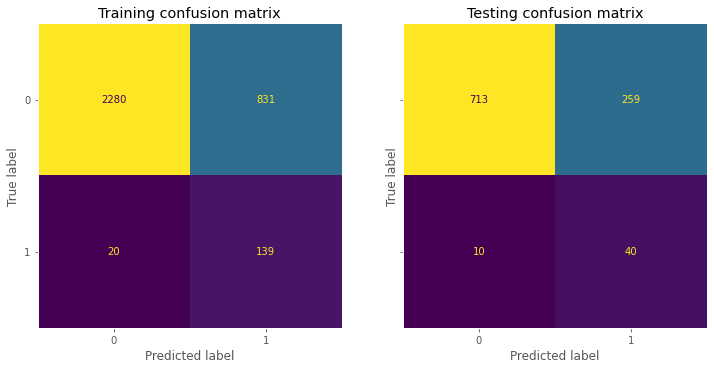

In [73]:
compare_cf_matrix(ens, X_train, X_test, y_train, y_test, size=(12, 8), normalize=None)
plt.show()

In [74]:
print(classification_report(y_test, ens.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84       972
           1       0.13      0.80      0.23        50

    accuracy                           0.74      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.74      0.81      1022



From the results we can see that the results aren't as good as with  
only the LogisticRegression - this model makes 259 false positives as  
opposed to 250 false positives of the regression, but it is better than  
standalone boosted tree models.  

In the next parts we will go though with predicting BMI, hypertension  
and glucose in various combinations.

## BMI prediction

### BMI regression

In [75]:
data = data.dropna()

In [76]:
miss_bmi = data.bmi.isna()
y = data[~miss_bmi].bmi.copy()
X = data[~miss_bmi].copy()
X = X.drop(["stroke", "bmi"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

There are missing bmi values, which i could try to impute, but as this is  
the target value and below we will see it is not very easy to predict I will  
just drop the missing data.

In [77]:
bmi_reg_pipe = make_pipe(X)

Again will go through multiple models to find the one that will perform best.

In [78]:
from sklearn.linear_model import ElasticNet

regression_models = {
    "RandomForestRegressor": {
        "model": [RandomForestRegressor()],
        "model__n_estimators": stats.randint(100, 2000),
        "model__min_samples_leaf": stats.randint(1, 50),
    },
    "ElasticNet": {
        "model": [ElasticNet()],
        "model__alpha": stats.loguniform(1e-3, 1e3),
        "model__l1_ratio": stats.uniform(),
        "model__max_iter": [10_000],
    },
    "ExtraTreesRegressor": {
        "model": [ExtraTreesRegressor()],
        "model__min_samples_leaf": stats.randint(1, 50),
        "model__n_estimators": stats.randint(100, 1000),
    },
    "AdaBoostRegressor": {
        "model": [AdaBoostRegressor()],
        "model__n_estimators": stats.randint(25, 75),
        "model__learning_rate": stats.loguniform(1e-3, 1),
    },
    "XGBoost": {
        "model": [xgb.XGBRegressor(verbosity=0, use_label_encoder=False)],
        "model__n_estimators": stats.randint(100, 2000),
        "model__learning_rate": stats.loguniform(3e-3, 1),
        "model__max_depth": stats.randint(1, 5),
        "model__min_child_weight": stats.randint(1, 10),
        "model__gamma": stats.uniform(0, 20),
        "model__reg_alpha": stats.uniform(1e-3, 10),
        "model__reg_lambda": stats.uniform(1e-3, 10),
    },
    "LightGBM": {
        "model": [lgbm.LGBMRegressor()],
        "model__n_estimators": stats.randint(200, 2000),
        "model__num_leaves": stats.randint(8, 200),
        "model__max_depth": stats.randint(3, 12),
        "model__learning_rate": stats.loguniform(3e-3, 0.05),
        "model__lambda_l1": stats.randint(0, 100),
        "model__lambda_l2": stats.randint(0, 100),
    },
    "Catboost": {
        "model": [cat.CatBoostRegressor(verbose=False)],
        "model__iterations": stats.randint(100, 1000),
        "model__depth": stats.randint(2, 10),
        "model__l2_leaf_reg": stats.randint(0, 100),
        "model__bagging_temperature": stats.randint(0, 50),
    },
}

In [79]:
# model_search = EstimatorSelectionHelper(regression_models, pipe)
# model_search.fit(X_train, y_train, scoring="neg_mean_squared_error", n_iter=10)

In [ ]:
# joblib.dump(model_search, "models/bmi_regression.dump")
bmi_regression = joblib.load("models/bmi_regression.dump")

In [81]:
search_results = (
    bmi_regression.score_summary()
    .sort_values(["mean_score", "estimator"], ascending=False)
    .groupby("estimator")
    .head(1)
)
search_results

,estimator,min_score,mean_score,max_score,std_score,params
59,LightGBM,-46.021527,-43.767305,-42.002295,1.676912,"{'model': LGBMRegressor(), 'model__lambda_l1':..."
64,Catboost,-46.515468,-43.897095,-42.076941,1.897893,{'model': <catboost.core.CatBoostRegressor obj...
44,XGBoost,-46.668268,-44.171914,-42.899038,1.765304,"{'model': XGBRegressor(base_score=None, booste..."
6,RandomForestRegressor,-47.083509,-44.310564,-42.310928,2.023675,"{'model': RandomForestRegressor(), 'model__min..."
22,ExtraTreesRegressor,-47.348402,-44.519144,-42.691487,2.028812,"{'model': ExtraTreesRegressor(), 'model__min_s..."
37,AdaBoostRegressor,-47.669942,-45.267617,-43.788017,1.713846,"{'model': AdaBoostRegressor(), 'model__learnin..."
13,ElasticNet,-49.219994,-46.369665,-44.250206,2.093693,"{'model': ElasticNet(), 'model__alpha': 0.0215..."


LightGBM did the best, but it seems it did not do too great.

In [82]:
best_params = search_results.head(1)["params"].values[0]

In [83]:
bmi_reg_pipe.set_params(**best_params)
_ = bmi_reg_pipe.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l2 is set=47, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47
[LightGBM] [Warning] lambda_l1 is set=73, reg_alpha=0.0 will be ignored. Current value: lambda_l1=73


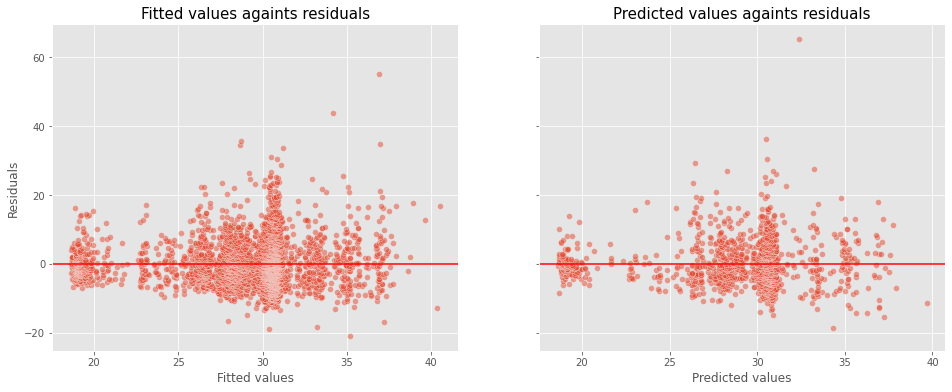

In [84]:
y_sort_train = y_train.sort_values()
x_sort_train = X_train.reindex(y_sort_train.index)
y_sort_test = y_test.sort_values()
x_sort_test = X_test.reindex(y_sort_test.index)

fitted = bmi_reg_pipe.predict(x_sort_train)
errors_fit = y_sort_train - fitted
prediction = bmi_reg_pipe.predict(x_sort_test)
errors_pred = y_sort_test - prediction
plot_compare_residuals(fitted, errors_fit, prediction, errors_pred)

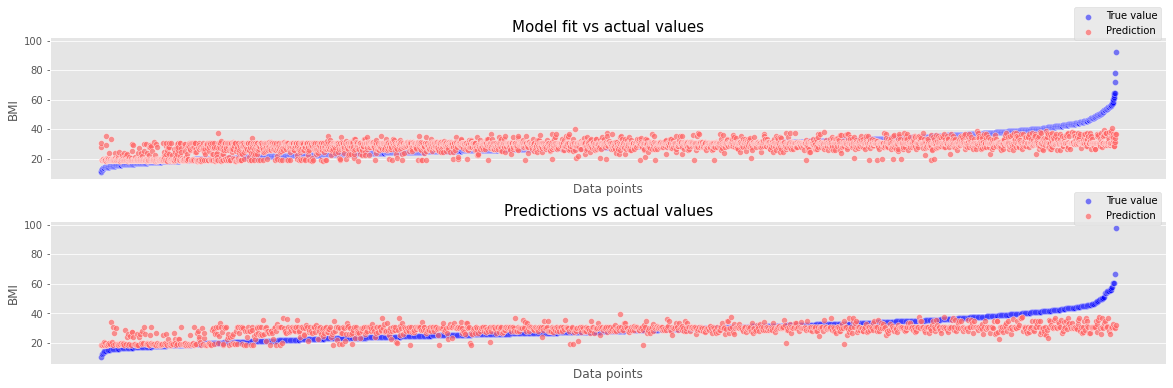

In [85]:
plot_compare_reg(fitted, y_sort_train, prediction, y_sort_test, "BMI")
plt.show()

Looks like the model underfits and resorts to predictions around the mean.

In [86]:
x_cat = X.select_dtypes("object").columns
x_num = X.select_dtypes(np.number).columns

feature_names = []
for i, col in enumerate(x_cat):
    if len(categories[i]) < 3:
        feature_names.append(col)
        continue
    for category in categories[i]:
        feature_names.append(f"{col}_{category}")
feature_names += list(x_num)

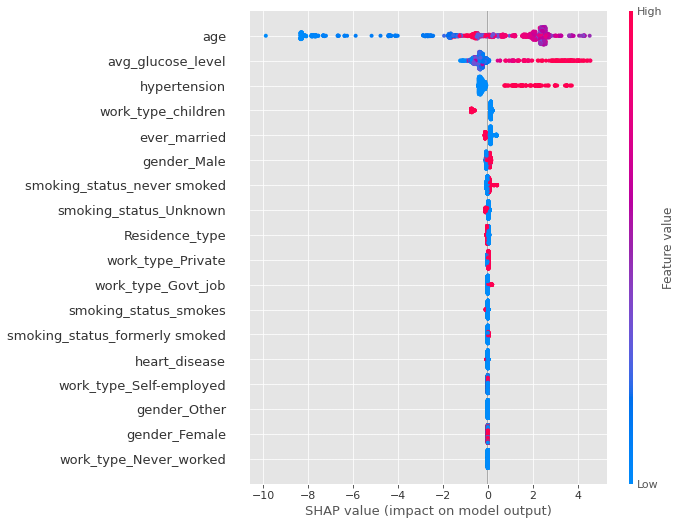

In [87]:
bmi_explainer = shap.TreeExplainer(bmi_reg_pipe["model"])
bmi_shap_values = bmi_explainer(bmi_reg_pipe["cat_trans"].transform(X_test))
shap.summary_plot(bmi_shap_values, feature_names=feature_names)

Again age was the most important, next is high glucose which could mean diabetes and obesity,  
also hypertension which can develop from excessive weight.

### BMI classification

To make things easier I will change the problem from regression to classification.

In [88]:
def discretize_bmi(value: float) -> str:
    """
    Splits values into low, normal and high and very high bmi
    """
    if value < 18.5:
        return 0
    elif 18.5 <= value <= 24.9:
        return 1
    elif 24.9 < value <= 30:
        return 2
    else:
        return 3


y = data["bmi"].copy()
y = y.apply(discretize_bmi)
X = data.copy()
X.drop(["stroke", "bmi"], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

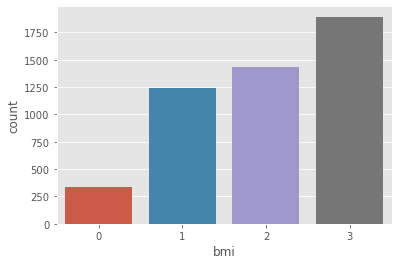

In [89]:
sns.countplot(x=y)
plt.show()

We can see that people with very high bmi values are dominating  
the dataset.

In [90]:
categories = [[i for i in data[col].unique() if i is not np.nan] for col in x_cat]
num_pipe = Pipeline([("scale", StandardScaler())])
cat_pipe = Pipeline(
    [("encode", OneHotEncoder(drop="if_binary", categories=categories))]
)

col_transform = ColumnTransformer(
    [
        ("cat", cat_pipe, x_cat),
        ("num", num_pipe, x_num),
    ]
)

pipe = ImPipeline([("cat_trans", col_transform), ("model", None)])

In [91]:
pipe = make_pipe(X)

In [92]:
# bmi_model_search = EstimatorSelectionHelper(classification_models, pipe)
# bmi_model_search.fit(X_train, y_train, scoring="f1_macro", n_iter=10)

In [ ]:
# joblib.dump(bmi_model_search, "models/bmi_class.dump")
bmi_model_search = joblib.load("models/bmi_class.dump")

In [94]:
search_results = (
    bmi_model_search.score_summary()
    .sort_values(["mean_score", "estimator"], ascending=False)
    .groupby("estimator")
    .head(1)
)
search_results

,estimator,min_score,mean_score,max_score,std_score,params
74,LightGBM,0.420059,0.442745,0.459944,0.016739,"{'model': LGBMClassifier(), 'model__lambda_l1'..."
80,Catboost,0.406856,0.442467,0.463556,0.025323,{'model': <catboost.core.CatBoostClassifier ob...
28,RandomForestClassifier,0.411771,0.44078,0.462833,0.021419,"{'model': RandomForestClassifier(), 'model__mi..."
62,XGBoost,0.412887,0.43497,0.468114,0.023865,"{'model': XGBClassifier(base_score=None, boost..."
6,SVC,0.417824,0.430068,0.44351,0.01052,"{'model': SVC(), 'model__C': 3.3324577442533516}"
39,ExtraTreesClassifier,0.415892,0.427316,0.433306,0.008081,"{'model': ExtraTreesClassifier(), 'model__min_..."
52,KNeighborsClassifier,0.412367,0.418243,0.423874,0.004701,"{'model': KNeighborsClassifier(n_neighbors=3),..."
12,LogisticRegression,0.374882,0.404792,0.422053,0.021233,"{'model': LogisticRegression(), 'model__C': 2...."
42,AdaBoostClassifier,0.389824,0.403752,0.423395,0.014289,"{'model': AdaBoostClassifier(), 'model__learni..."


LightGBM again performed the best

In [95]:
best_params = search_results.head(1)["params"].values[0]

In [96]:
best_params["model__reg_lambda"] = best_params["model__lambda_l2"]
best_params["model__reg_alpha"] = best_params["model__lambda_l1"]
del best_params["model__lambda_l1"]
del best_params["model__lambda_l2"]
best_params

{'model': LGBMClassifier(),
 'model__learning_rate': 0.027776721548202765,
 'model__max_depth': 3,
 'model__n_estimators': 1720,
 'model__num_leaves': 163,
 'model__reg_lambda': 16,
 'model__reg_alpha': 2}

In [97]:
# pipe.set_params(**best_params)
# pipe.fit(X_train, y_train)

In [ ]:
# joblib.dump(pipe, "models/bmi_model.dump")
pipe = joblib.load("models/bmi_model.dump")

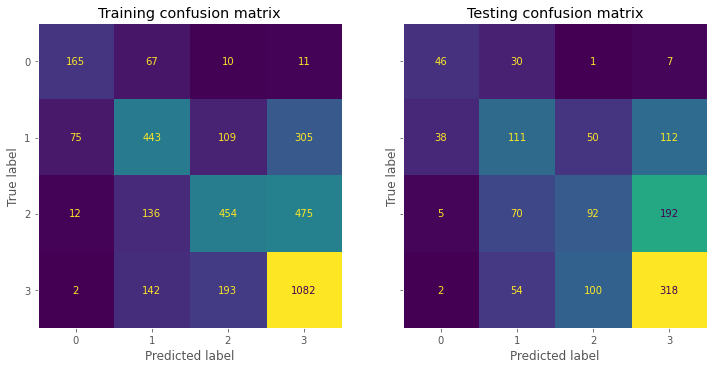

In [99]:
compare_cf_matrix(pipe, X_train, X_test, y_train, y_test, size=(12, 8), normalize=None)
plt.show()

In [100]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.51      0.55      0.53        84
           1       0.42      0.36      0.39       311
           2       0.38      0.26      0.31       359
           3       0.51      0.67      0.58       474

    accuracy                           0.46      1228
   macro avg       0.45      0.46      0.45      1228
weighted avg       0.45      0.46      0.45      1228



Still the model overall isn't too great.

## Hypertension predictor

Moving to hypertension.

In [101]:
y = data["hypertension"].copy()
X = data.copy()
X = X.drop(["stroke", "hypertension"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

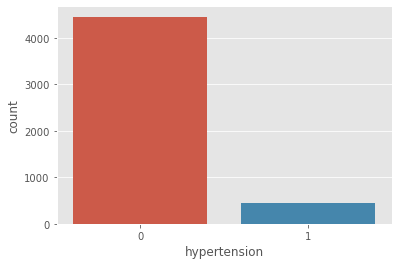

In [102]:
sns.countplot(x=y)
plt.show()

Just like with stroke the classes are very imbalanced.

In [103]:
hype_pipe = make_pipe(X, sampler=SMOTE())

In [104]:
# model_search = EstimatorSelectionHelper(classification_models, hype_pipe)
# model_search.fit(X_train, y_train, scoring="balanced_accuracy", n_iter=10)

In [ ]:
# joblib.dump(model_search, "models/hyp_pred.dump")
model_search = joblib.load("models/hyp_pred.dump")

In [106]:
search_results = (
    model_search.score_summary()
    .sort_values(["mean_score", "estimator"], ascending=False)
    .groupby("estimator")
    .head(1)
)
search_results

,estimator,min_score,mean_score,max_score,std_score,params
15,LogisticRegression,0.698775,0.742476,0.795068,0.039811,"{'model': LogisticRegression(), 'model__C': 7...."
1,SVC,0.715574,0.729869,0.751169,0.015352,"{'model': SVC(), 'model__C': 0.010886532775877..."
75,LightGBM,0.689779,0.719186,0.77343,0.038402,"{'model': LGBMClassifier(lambda_l1=2, lambda_l..."
49,AdaBoostClassifier,0.711909,0.715375,0.720364,0.003616,"{'model': AdaBoostClassifier(), 'model__learni..."
67,XGBoost,0.671186,0.707084,0.741801,0.028841,"{'model': XGBClassifier(base_score=None, boost..."
54,KNeighborsClassifier,0.652986,0.684509,0.708489,0.023278,"{'model': KNeighborsClassifier(n_neighbors=3),..."
32,ExtraTreesClassifier,0.675895,0.683732,0.69422,0.007712,"{'model': ExtraTreesClassifier(), 'model__min_..."
25,RandomForestClassifier,0.640988,0.663282,0.679832,0.01637,"{'model': RandomForestClassifier(), 'model__mi..."
87,Catboost,0.59829,0.620391,0.634268,0.015797,{'model': <catboost.core.CatBoostClassifier ob...


Again as with stroke for this binary problem Logistic Regression did pretty well.

In [107]:
hype_pipe.set_params(**search_results.head(1)["params"].values[0])
_ = hype_pipe.fit(X_train, y_train)

In [108]:
joblib.dump(hype_pipe, "models/hyp_model.dump")

['models/hyp_model.dump']

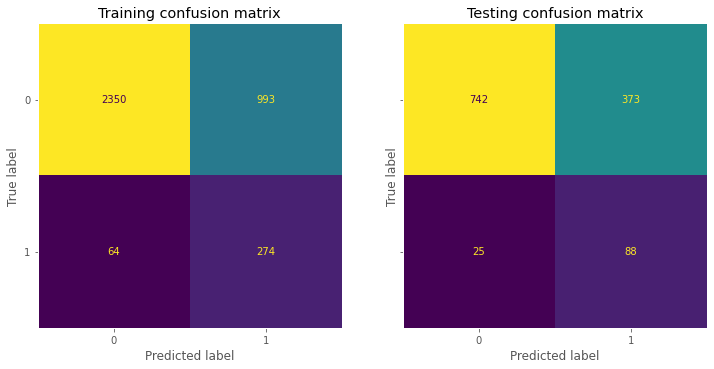

In [109]:
compare_cf_matrix(
    hype_pipe, X_train, X_test, y_train, y_test, size=(12, 8), normalize=None
)
plt.show()

In [110]:
print(classification_report(y_test, hype_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.67      0.79      1115
           1       0.19      0.78      0.31       113

    accuracy                           0.68      1228
   macro avg       0.58      0.72      0.55      1228
weighted avg       0.90      0.68      0.74      1228



Also as with stroke predictions we are making many false positives  

but at the same time have an okay recall.

In [111]:
x_cat = X.select_dtypes("object").columns
x_num = X.select_dtypes(np.number).columns

feature_names = []
for i, col in enumerate(x_cat):
    if len(categories[i]) < 3:
        feature_names.append(col)
        continue
    for category in categories[i]:
        feature_names.append(f"{col}_{category}")
feature_names += list(x_num)

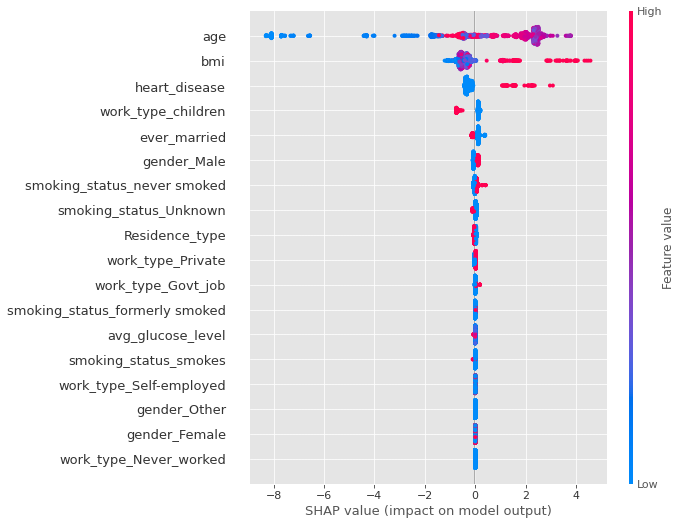

In [112]:
hyp_explainer = shap.Explainer(LogisticRegression)
hyp_shap_values = bmi_explainer(hype_pipe["cat_trans"].transform(X_test))
shap.summary_plot(hyp_shap_values, feature_names=feature_names)

Again age, bmi and heart disease are pretty important.

## Average glucose level predictor

Finally the glucose level predictions.

### Glucose level regression

In [113]:
y = data["avg_glucose_level"].copy()
X = data.copy()
X = X.drop(["stroke", "avg_glucose_level"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [114]:
glu_reg_pipe = make_pipe(X)

In [115]:
# model_search = EstimatorSelectionHelper(regression_models, glu_reg_pipe)
# model_search.fit(X_train, y_train, scoring="neg_mean_squared_error", n_iter=10)

In [ ]:
# joblib.dump(model_search, "models/glu_reg.dump")
model_search = joblib.load("models/glu_reg.dump")

In [117]:
search_results = (
    model_search.score_summary()
    .sort_values(["mean_score", "estimator"], ascending=False)
    .groupby("estimator")
    .head(1)
)
search_results

,estimator,min_score,mean_score,max_score,std_score,params
69,Catboost,-2011.211574,-1840.750163,-1736.089765,121.573935,{'model': <catboost.core.CatBoostRegressor obj...
0,RandomForestRegressor,-2041.662576,-1857.797749,-1744.306097,131.19834,"{'model': RandomForestRegressor(), 'model__min..."
32,AdaBoostRegressor,-2038.062514,-1860.008036,-1765.291358,125.989199,"{'model': AdaBoostRegressor(), 'model__learnin..."
47,XGBoost,-2043.62006,-1867.670555,-1778.3453,124.419974,"{'model': XGBRegressor(base_score=None, booste..."
14,ElasticNet,-2052.070706,-1870.968114,-1770.309903,128.324488,"{'model': ElasticNet(), 'model__alpha': 0.0543..."
54,LightGBM,-2041.224192,-1873.024231,-1767.064401,120.267128,"{'model': LGBMRegressor(), 'model__lambda_l1':..."
29,ExtraTreesRegressor,-2039.589084,-1877.44509,-1793.673238,114.674308,"{'model': ExtraTreesRegressor(), 'model__min_s..."


In this case catboost did the best

In [118]:
best_params = search_results.head(1)["params"].values[0]

In [119]:
del best_params["model"]

In [120]:
glu_reg_pipe.set_params(model=cat.CatBoostRegressor(verbose=0), **best_params)
_ = glu_reg_pipe.fit(X_train, y_train)

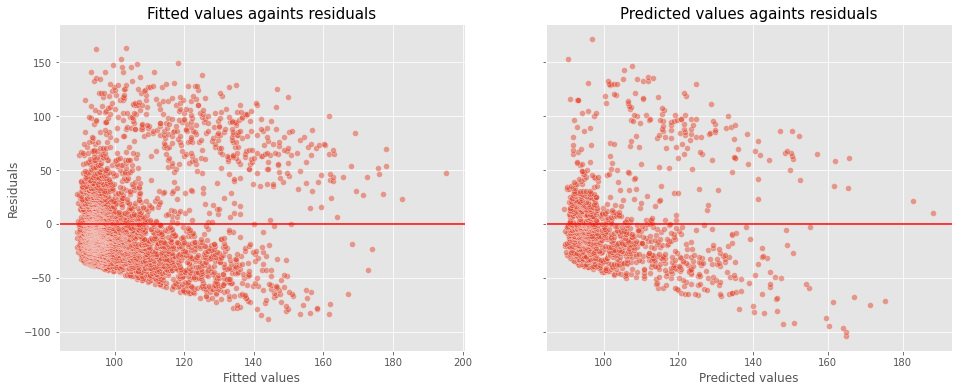

In [121]:
y_sort_train = y_train.sort_values()
x_sort_train = X_train.reindex(y_sort_train.index)
y_sort_test = y_test.sort_values()
x_sort_test = X_test.reindex(y_sort_test.index)

fitted = glu_reg_pipe.predict(x_sort_train)
errors_fit = y_sort_train - fitted
prediction = glu_reg_pipe.predict(x_sort_test)
errors_pred = y_sort_test - prediction
plot_compare_residuals(fitted, errors_fit, prediction, errors_pred)

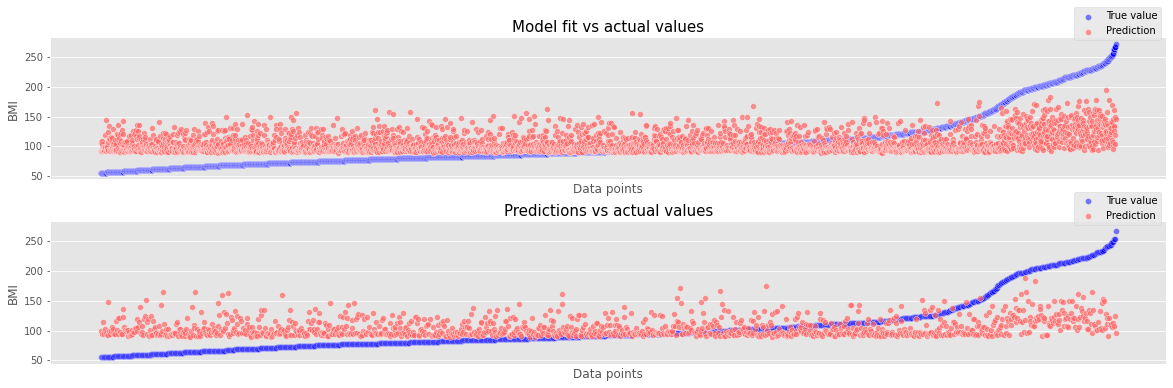

In [122]:
plot_compare_reg(fitted, y_sort_train, prediction, y_sort_test, "BMI")
plt.show()

But looking at the result they are not great, the model like in bmi's case  
predicts around the mean.

In [123]:
x_cat = X.select_dtypes("object").columns
x_num = X.select_dtypes(np.number).columns

feature_names = []
for i, col in enumerate(x_cat):
    if len(categories[i]) < 3:
        feature_names.append(col)
        continue
    for category in categories[i]:
        feature_names.append(f"{col}_{category}")
feature_names += list(x_num)

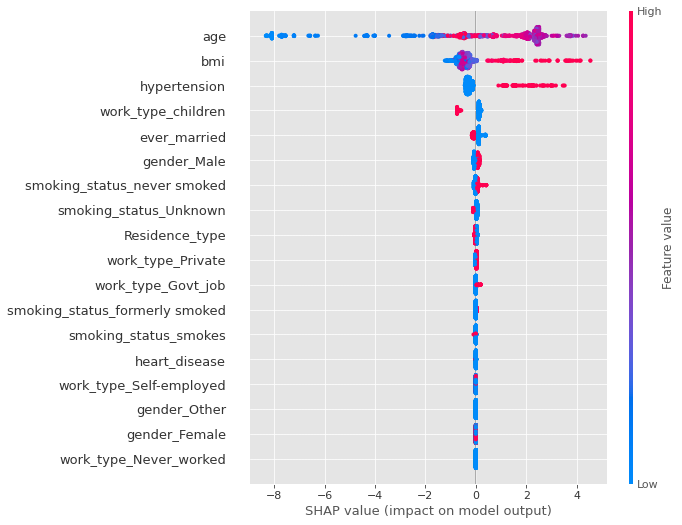

In [124]:
glu_explainer = shap.TreeExplainer(glu_reg_pipe["model"])
glu_shap_values = bmi_explainer(glu_reg_pipe["cat_trans"].transform(X_test))
shap.summary_plot(glu_shap_values, feature_names=feature_names)

Once again age, bmi and hypertension are important.

### Glucose level classification

Again lets try to simplify the problem my making it classification one.

In [125]:
def discretize_glu(value: float) -> str:
    """
    Split glucose levels into low, normal, pre-diabetes and diabetes.
    """
    if value < 70:
        return 0
    elif 70 <= value < 140:
        return 1
    elif 140 <= value < 200:
        return 2
    else:
        return 3


y = data["avg_glucose_level"].copy()
X = data.copy()
y = y.apply(discretize_glu)
X = X.drop(["stroke", "avg_glucose_level"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

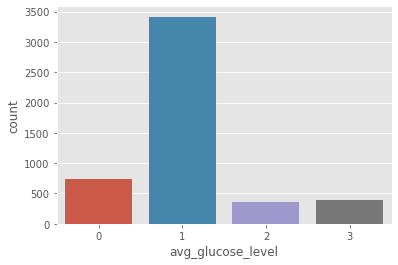

In [126]:
sns.countplot(x=y)
plt.show()

Most people seem to have normal blood glucose levels.

In [127]:
glu_pipe = make_pipe(X, sampler=SMOTE())

In [128]:
# model_search = EstimatorSelectionHelper(classification_models, glu_pipe)
# model_search.fit(X_train, y_train, scoring="balanced_accuracy", n_iter=10)

In [ ]:
# joblib.dump(model_search, "models/glu_class.dump")
model_search = joblib.load("models/glu_class.dump")

In [130]:
search_results = (
    model_search.score_summary()
    .sort_values(["mean_score", "estimator"], ascending=False)
    .groupby("estimator")
    .head(1)
)
search_results

,estimator,min_score,mean_score,max_score,std_score,params
16,LogisticRegression,0.35923,0.382047,0.393615,0.016135,{'model': LogisticRegression(C=0.0023995021846...
61,XGBoost,0.365026,0.371097,0.383077,0.008472,"{'model': XGBClassifier(base_score=None, boost..."
44,AdaBoostClassifier,0.364819,0.368883,0.37437,0.004027,"{'model': AdaBoostClassifier(), 'model__learni..."
76,LightGBM,0.361574,0.368733,0.381111,0.008789,"{'model': LGBMClassifier(), 'model__learning_r..."
6,SVC,0.359963,0.360824,0.362436,0.001141,"{'model': SVC(), 'model__C': 0.007073838109843..."
88,Catboost,0.352567,0.354913,0.356366,0.001674,{'model': <catboost.core.CatBoostClassifier ob...
27,RandomForestClassifier,0.327716,0.337493,0.351629,0.010238,"{'model': RandomForestClassifier(), 'model__mi..."
33,ExtraTreesClassifier,0.318427,0.328199,0.340075,0.008962,"{'model': ExtraTreesClassifier(), 'model__min_..."
50,KNeighborsClassifier,0.314054,0.322163,0.336322,0.010047,"{'model': KNeighborsClassifier(), 'model__n_ne..."


Again the simple model wins

In [131]:
best_params = search_results.head(1)["params"].values[0]

In [132]:
glu_pipe.set_params(**best_params)
# glu_pipe.fit(X_train, y_train)

Pipeline(steps=[('cat_trans',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(categories=[['Male',
                                                                             'Female',
                                                                             'Other'],
                                                                            ['Yes',
                                                                             'No'],
                                                                            ['Private',
                                                                             'Self-employed',
                                                                             'Govt_job',
                                                                             'children',
                                                                             'Never_worked'],
                                

In [ ]:
# joblib.dump(glu_pipe, "models/glu_model.dump")
glu_pipe = joblib.load("models/glu_model.dump")

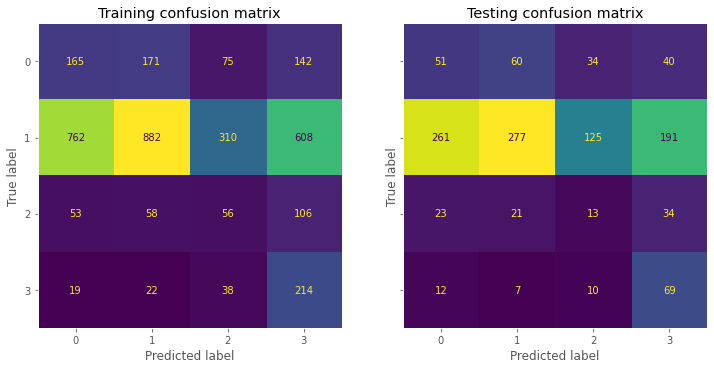

In [134]:
compare_cf_matrix(
    glu_pipe, X_train, X_test, y_train, y_test, size=(12, 8), normalize=None
)
plt.show()

In [135]:
print(classification_report(y_test, glu_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.15      0.28      0.19       185
           1       0.76      0.32      0.45       854
           2       0.07      0.14      0.10        91
           3       0.21      0.70      0.32        98

    accuracy                           0.33      1228
   macro avg       0.30      0.36      0.27      1228
weighted avg       0.57      0.33      0.38      1228



But the predictions are quite bad.

In the final parts we will be creating multi output models to predict  
multiple things at once, the models were not great before and removing  
will likely not improve them much. In the end we will be left with only  
one numeric value - age, this should restrict the possible predictions as we  
will have only so many possible combinations of values between categorical  
features and age.

## Glucose-BMI predictor

In [136]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay

In [137]:
y = data[["avg_glucose_level", "bmi"]].copy()
y["avg_glucose_level"] = y["avg_glucose_level"].apply(discretize_glu)
y["bmi"] = y["bmi"].apply(discretize_bmi)
X = data.copy()
X = X.drop(["stroke", "avg_glucose_level", "bmi"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [138]:
glu_bmi_pipe = make_pipe(X, sampler=SMOTE())
glu_bmi_pipe.set_params(model=LogisticRegressionCV(Cs=100, max_iter=10000))
glu_bmi_model = MultiOutputClassifier(glu_bmi_pipe)

Because simple regression models did pretty good in all the models  
that are left I will only use it.

In [139]:
# glu_bmi_model.fit(X_train, y_train)

In [ ]:
# joblib.dump(glu_bmi_model, "models/glu_bmi_class.dump")
glu_bmi_model = joblib.load("models/glu_bmi_class.dump")

In [141]:
glu_bmi_model.estimators_[0]["model"]

LogisticRegressionCV(Cs=100, max_iter=10000)

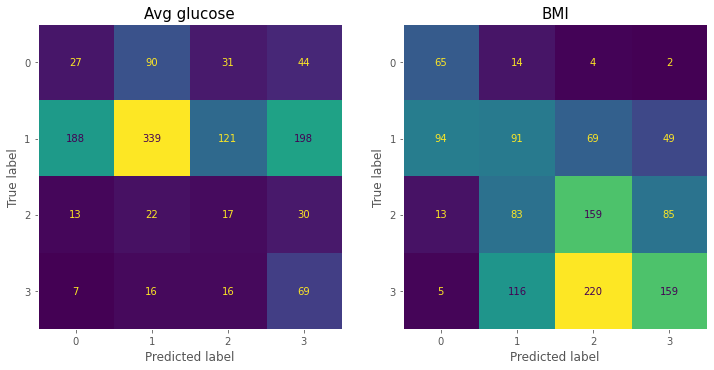

In [142]:
glu = glu_bmi_model.estimators_[0]
bmi = glu_bmi_model.estimators_[1]

fit, ax = plt.subplots(1, 2, figsize=(12, 8))

ConfusionMatrixDisplay.from_estimator(
    glu["model"],
    glu["cat_trans"].transform(X_test),
    y_test.iloc[:, 0],
    colorbar=False,
    ax=ax[0],
)
ax[0].set_title("Avg glucose", fontsize=15)
ax[0].grid(False)
ConfusionMatrixDisplay.from_estimator(
    bmi["model"],
    bmi["cat_trans"].transform(X_test),
    y_test.iloc[:, 1],
    colorbar=False,
    ax=ax[1],
)
ax[1].set_title("BMI", fontsize=15)
ax[1].grid(False)

In [143]:
print(
    classification_report(
        y_test.iloc[:, 0], glu["model"].predict(glu["cat_trans"].transform(X_test))
    )
)

              precision    recall  f1-score   support

           0       0.11      0.14      0.13       192
           1       0.73      0.40      0.52       846
           2       0.09      0.21      0.13        82
           3       0.20      0.64      0.31       108

    accuracy                           0.37      1228
   macro avg       0.28      0.35      0.27      1228
weighted avg       0.54      0.37      0.41      1228



In [144]:
print(
    classification_report(
        y_test.iloc[:, 1], bmi["model"].predict(bmi["cat_trans"].transform(X_test))
    )
)

              precision    recall  f1-score   support

           0       0.37      0.76      0.50        85
           1       0.30      0.30      0.30       303
           2       0.35      0.47      0.40       340
           3       0.54      0.32      0.40       500

    accuracy                           0.39      1228
   macro avg       0.39      0.46      0.40      1228
weighted avg       0.42      0.39      0.38      1228



Glucose predictions again seem pretty bad.

## Glucose-hypertension predictor

In [145]:
y = data[["avg_glucose_level", "hypertension"]].copy()
y["avg_glucose_level"] = y["avg_glucose_level"].apply(discretize_glu)
X = data.copy()
X = X.drop(["stroke", "avg_glucose_level", "hypertension"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [146]:
glu_hyp_pipe = make_pipe(X, sampler=SMOTE())
glu_hyp_pipe.set_params(model=LogisticRegressionCV(Cs=100, max_iter=10000))
glu_hyp_model = MultiOutputClassifier(glu_hyp_pipe)

In [147]:
# glu_hyp_model.fit(X_train, y_train)

In [ ]:
# joblib.dump(glu_hyp_model, "models/glu_hyp_class.dump")
glu_hyp_model = joblib.load("models/glu_hyp_class.dump")

In [149]:
glu_hyp_model.estimators_[0]["model"]

LogisticRegressionCV(Cs=100, max_iter=10000)

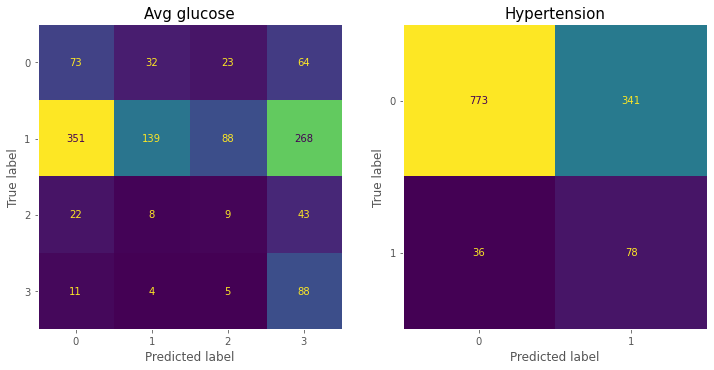

In [150]:
glu = glu_hyp_model.estimators_[0]
hyp = glu_hyp_model.estimators_[1]

fit, ax = plt.subplots(1, 2, figsize=(12, 8))

ConfusionMatrixDisplay.from_estimator(
    glu["model"],
    glu["cat_trans"].transform(X_test),
    y_test.iloc[:, 0],
    colorbar=False,
    ax=ax[0],
)
ax[0].set_title("Avg glucose", fontsize=15)
ax[0].grid(False)
ConfusionMatrixDisplay.from_estimator(
    hyp["model"],
    hyp["cat_trans"].transform(X_test),
    y_test.iloc[:, 1],
    colorbar=False,
    ax=ax[1],
)
ax[1].set_title("Hypertension", fontsize=15)
ax[1].grid(False)

In [151]:
print(
    classification_report(
        y_test.iloc[:, 0], glu["model"].predict(glu["cat_trans"].transform(X_test))
    )
)

              precision    recall  f1-score   support

           0       0.16      0.38      0.22       192
           1       0.76      0.16      0.27       846
           2       0.07      0.11      0.09        82
           3       0.19      0.81      0.31       108

    accuracy                           0.25      1228
   macro avg       0.30      0.37      0.22      1228
weighted avg       0.57      0.25      0.25      1228



In [152]:
print(
    classification_report(
        y_test.iloc[:, 1], hyp["model"].predict(hyp["cat_trans"].transform(X_test))
    )
)

              precision    recall  f1-score   support

           0       0.96      0.69      0.80      1114
           1       0.19      0.68      0.29       114

    accuracy                           0.69      1228
   macro avg       0.57      0.69      0.55      1228
weighted avg       0.88      0.69      0.76      1228



Once again glucose predictions aren't great.

## Hypertension-BMI

In [153]:
y = data[["hypertension", "bmi"]].copy()
y["bmi"] = y["bmi"].apply(discretize_bmi)
X = data.copy()
X = X.drop(["stroke", "bmi", "hypertension"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [154]:
bmi_hyp_pipe = make_pipe(X, sampler=SMOTE())
bmi_hyp_pipe.set_params(model=LogisticRegressionCV(Cs=100, max_iter=10000))
bmi_hyp_model = MultiOutputClassifier(bmi_hyp_pipe)

In [155]:
# bmi_hyp_model.fit(X_train, y_train)

In [ ]:
# joblib.dump(bmi_hyp_model, "models/bmi_hyp_class.dump")
bmi_hyp_model = joblib.load("models/bmi_hyp_class.dump")

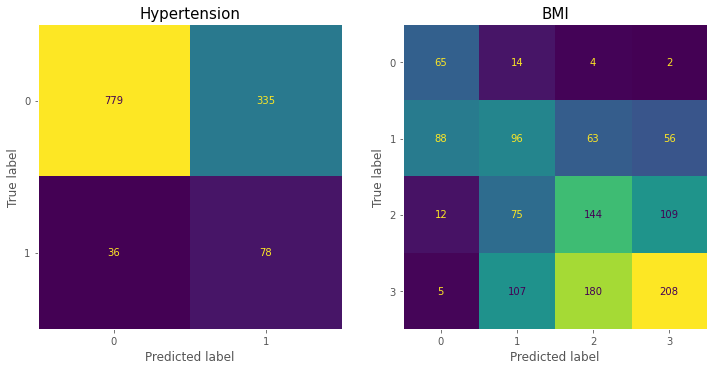

In [157]:
hyp = bmi_hyp_model.estimators_[0]
bmi = bmi_hyp_model.estimators_[1]

fit, ax = plt.subplots(1, 2, figsize=(12, 8))

ConfusionMatrixDisplay.from_estimator(
    hyp["model"],
    hyp["cat_trans"].transform(X_test),
    y_test.iloc[:, 0],
    colorbar=False,
    ax=ax[0],
)
ax[0].set_title("Hypertension", fontsize=15)
ax[0].grid(False)
ConfusionMatrixDisplay.from_estimator(
    bmi["model"],
    bmi["cat_trans"].transform(X_test),
    y_test.iloc[:, 1],
    colorbar=False,
    ax=ax[1],
)
ax[1].set_title("BMI", fontsize=15)
ax[1].grid(False)

In [158]:
print(
    classification_report(
        y_test.iloc[:, 0], hyp["model"].predict(hyp["cat_trans"].transform(X_test))
    )
)

              precision    recall  f1-score   support

           0       0.96      0.70      0.81      1114
           1       0.19      0.68      0.30       114

    accuracy                           0.70      1228
   macro avg       0.57      0.69      0.55      1228
weighted avg       0.88      0.70      0.76      1228



In [159]:
print(
    classification_report(
        y_test.iloc[:, 1], bmi["model"].predict(bmi["cat_trans"].transform(X_test))
    )
)

              precision    recall  f1-score   support

           0       0.38      0.76      0.51        85
           1       0.33      0.32      0.32       303
           2       0.37      0.42      0.39       340
           3       0.55      0.42      0.48       500

    accuracy                           0.42      1228
   macro avg       0.41      0.48      0.43      1228
weighted avg       0.44      0.42      0.42      1228



## Hypertesion-BMI-glucose

In [160]:
y = data[["hypertension", "bmi", "avg_glucose_level"]].copy()
y["avg_glucose_level"] = y["avg_glucose_level"].apply(discretize_glu)
y["bmi"] = y["bmi"].apply(discretize_bmi)
X = data.copy()
X = X.drop(["stroke", "bmi", "hypertension", "avg_glucose_level"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [161]:
hyp_bmi_glu_pipe = make_pipe(X, sampler=SMOTE())
hyp_bmi_glu_pipe.set_params(model=LogisticRegressionCV(Cs=100, max_iter=10000))
hyp_bmi_glu_model = MultiOutputClassifier(hyp_bmi_glu_pipe)

In [162]:
# hyp_bmi_glu_model.fit(X_train, y_train)

In [ ]:
# joblib.dump(hyp_bmi_glu_model, "models/hyp_bmi_glu_class.dump")
hyp_bmi_glu_model = joblib.load("models/hyp_bmi_glu_class.dump")

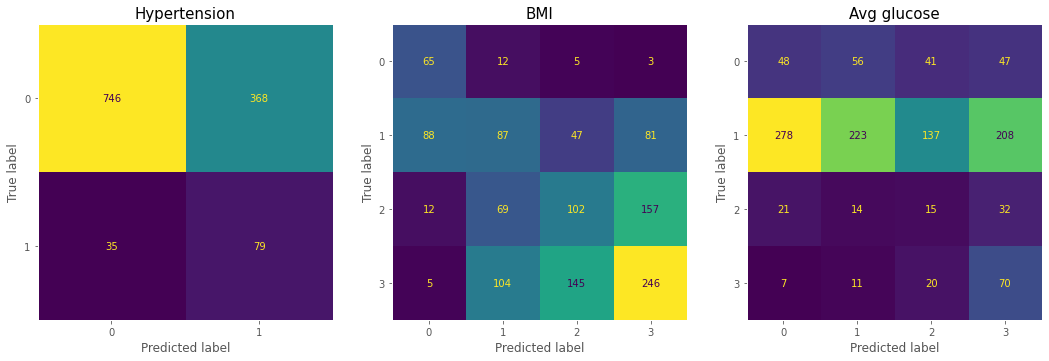

In [164]:
hyp = hyp_bmi_glu_model.estimators_[0]
bmi = hyp_bmi_glu_model.estimators_[1]
glu = hyp_bmi_glu_model.estimators_[2]


fit, ax = plt.subplots(1, 3, figsize=(18, 8))

ConfusionMatrixDisplay.from_estimator(
    hyp["model"],
    hyp["cat_trans"].transform(X_test),
    y_test.iloc[:, 0],
    colorbar=False,
    ax=ax[0],
)
ax[0].set_title("Hypertension", fontsize=15)

ax[0].grid(False)
ConfusionMatrixDisplay.from_estimator(
    bmi["model"],
    bmi["cat_trans"].transform(X_test),
    y_test.iloc[:, 1],
    colorbar=False,
    ax=ax[1],
)
ax[1].set_title("BMI", fontsize=15)

ax[1].grid(False)
ConfusionMatrixDisplay.from_estimator(
    glu["model"],
    glu["cat_trans"].transform(X_test),
    y_test.iloc[:, 2],
    colorbar=False,
    ax=ax[2],
)
ax[2].set_title("Avg glucose", fontsize=15)
ax[2].grid(False)

In [165]:
print(
    classification_report(
        y_test.iloc[:, 0], hyp["model"].predict(hyp["cat_trans"].transform(X_test))
    )
)

              precision    recall  f1-score   support

           0       0.96      0.67      0.79      1114
           1       0.18      0.69      0.28       114

    accuracy                           0.67      1228
   macro avg       0.57      0.68      0.53      1228
weighted avg       0.88      0.67      0.74      1228



In [166]:
print(
    classification_report(
        y_test.iloc[:, 1], bmi["model"].predict(bmi["cat_trans"].transform(X_test))
    )
)

              precision    recall  f1-score   support

           0       0.38      0.76      0.51        85
           1       0.32      0.29      0.30       303
           2       0.34      0.30      0.32       340
           3       0.51      0.49      0.50       500

    accuracy                           0.41      1228
   macro avg       0.39      0.46      0.41      1228
weighted avg       0.41      0.41      0.40      1228



In [167]:
print(
    classification_report(
        y_test.iloc[:, 2], glu["model"].predict(glu["cat_trans"].transform(X_test))
    )
)

              precision    recall  f1-score   support

           0       0.14      0.25      0.18       192
           1       0.73      0.26      0.39       846
           2       0.07      0.18      0.10        82
           3       0.20      0.65      0.30       108

    accuracy                           0.29      1228
   macro avg       0.28      0.34      0.24      1228
weighted avg       0.55      0.29      0.33      1228



All the model are not great, but they are also not as bad as  
I was expecting, except for glucose levels.

# Conclusions

The most important factor to predict strokes seems to be your age at least  
from this dataset.

About the models I think in my future projects I should first run models  
without any parameter tuning and pick the better ones from those for further  
improvements.

Also I should have encoded hypertension, and heart disease as categorical data  
form the start, because now after scaling they change form 0-1 to 0-3 and it might  
influence the model in a negative, although it might not be that important especially  
in tree models.

